   # Применение метода Воронцова-Успенского

Все предварительная (и на самом деле самая большая часть работы) была выполнена в матлабе. В этом ноутбуке только применение этих данных. Исходные сигнала сначала подвергались фильтрации. Использовались совершенно разные фильтры, различные варианты сглаживания скользящими окнами(в этой задаче работали они далеко не все). Лучшим методом фильрации и выбранным на даннной момент - фильтры высоких и низких частот с помощью преобразования Фурье. Исходный сигал подвергается FFT, затем зануляются определенные частоты, (какие именно занулять я честно нашел в интернете) а затем применялось обратного преобразование. В результате вредных частот в сигнале уже не было.
Далее на отфильрованных сигналах происходило выделение J максимумов. Был использован простой, но очень хорошо показавший себя подход: все точки сигнала проверялись на то, что они являются локальным максимумом, но не просто локальным масимумом, а слева и справа точки принимают значение < 0. Это простой и довольно неэффективный метод с точки зрения работы с памятью, но визуально он показал качество лучше, чем любая готовая матлабовская библиотека (а опробовано  и проверено было совсем не мало библиотек), например https://www.mathworks.com/examples/wavelet/mw/wavelet-ex77408607-r-wave-detection-in-the-ecg. В результате работы данного алгоритма для каждого сигнала мы получаем список интервалов (расстояний между соседними максимуми) и амплитуд (высота каждого максимума).
Далее это последовательность записывается в текстовый файл, с которым потом уже можно работать с помощью любого другого языка, у которого есть хорошие ML библиотеки (R, python, etc). Для больных и здоровых существует два отдельных файла (ibs_true_data.txt- больные, ibs_false_data.txt - здоровые)
Формат текстового файла такой:

"Patient" +Номер пацента + "Cardio" + Номер сигнала

список амплитуд

пустая строка

список интервалов

"Patient" +Номер пацента + "Cardio" + Номер сигнала

Такой формат позволяет быстро обработать этот файлик, выделяя кардиограммы, которые относятся только к одному пациенту




Вот так выглядит сигнал после указанной выше фильтрации (маленький кусок реального сигнала, реальных пиков гораздо больше):
<img src="signals_after_filters.jpg">

А вот так на этом же сигнале (но это уже весь сигнал после фильтрации, а не кусок, как прошлый) алгоритм находит максимумы.Визуально видно, что довольно хорошая точность
<img src="peak_detection2.jpg">

Здесь кратко раcсмотрим метод Воронцова-Успенского.
Наш сигнал с помощью выделения максимумов разбит на отрезки. Для этого разбиения вычисляется три последовательности: знак разности соседних амплитуд, знак разности соседних интервалов и знак разности соседних углов. Угл в данном случае это арктангенс(амплитуда/интервал).  Всего возмждно не 8 вариантов, а только 6, так как угол явно связан с амплитудой и интервалом. Таким образом каждый сигнал можно представить как последовать букв из алфавита по модулю 6. Далее с ним можно работать уже как как с текстом, используя обычные приемы выделения признаков и обычные алгоритмы классификации (например количество у кардиограммы буквы, которая характерна для больных и т.д.)

Если посмотреть, сколько раз встречается в среднем каждая триграмма у больных и здоровых, то график будет выглядеть примерно так:
<img src="trigrams.png">
Очень мало триграмм, которые встречаются только у больных или только у здоровых, но они есть

In [23]:
a = np.array([1,2,3])
import scipy.stats
f1 = lambda x : np.percentile(a=x, q=50)
print np.var(a)
print scipy.stats.moment(a,1)

0.666666666667
0.0


Теперь перейдем к коду непосредственного алгоритма

In [75]:
# -*- coding: utf-8 -*-
import numpy as np
from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
class CardioClass():
    def __init__(self, path_to_true_ibs, path_to_false_ibs):
        self.ibs_true_patients = {}   # заводим словари, которые по номерку  пациента дадут данные
        self.ibs_false_patients = {}
        k = 0            # номер текущего пациента
        new_ids = {}     # словарь с айдишниками пациентов, мы дадим им нормальные айдишники, которые нумеруются с 0
        with open(path_to_true_ibs) as true_abs_file:   # сначала работаем с больными пациентами
            while True:      #cчитываем данные, пока можем
                patient_cardio_id = true_abs_file.readline().strip().split()#номер пациента и номер сигнала
                if not patient_cardio_id:    # если это пустая строчка, то закончиили считывать            
                    break
                old_patient_id = patient_cardio_id[1]  # в такой записи файла номер пациента стоит на 1 позиции
                cardio_id = patient_cardio_id[3]       # номер сигнала на 3
                amplitudes = [float(x) for x in true_abs_file.readline().strip().split()] # взяли спислк амплитуд
                true_abs_file.readline()
                intervals = [float(x) for x in true_abs_file.readline().strip().split()] # взяли список интервалов
                if old_patient_id not in new_ids:  # если мы не видели ранее, добавили его
                    new_ids[old_patient_id] = k    # присвоили ему новый номер
                    k += 1
                old_patient_id = new_ids[old_patient_id]  #вот это ноый номер пациента
                if old_patient_id not in self.ibs_true_patients:  # если он новый, создадим ему новый список с данными
                    self.ibs_true_patients[old_patient_id] = [(self.make_trigrams_data(amplitudes, intervals), (amplitudes, intervals))]
                else:  # иначе добавим к уже известным ранее ему данным
                    self.ibs_true_patients[old_patient_id].append([self.make_trigrams_data(amplitudes, intervals), (amplitudes, intervals)])
        
        
        with open(path_to_false_ibs) as false_abs_file:    #абсолютно тоже самое, но уже для здоровых пациентов
            while True:
                patient_cardio_id = false_abs_file.readline().strip().split()
                if not patient_cardio_id:
                    break
                amplitudes = [float(x) for x in false_abs_file.readline().strip().split()]
                false_abs_file.readline()
                intervals = [float(x) for x in false_abs_file.readline().strip().split()]
                old_patient_id = patient_cardio_id[1]
                cardio_id = patient_cardio_id[3]
                if old_patient_id not in new_ids:
                    new_ids[old_patient_id] = k
                    k += 1
                old_patient_id = new_ids[old_patient_id]
                if old_patient_id not in self.ibs_false_patients:
                    self.ibs_false_patients[old_patient_id] = [(self.make_trigrams_data(amplitudes, intervals), (amplitudes, intervals))]
                else:
                    self.ibs_false_patients[old_patient_id].append([self.make_trigrams_data(amplitudes, intervals), (amplitudes, intervals)])

    def make_trigrams_data(self, amps, ints):   # функция, которая по списку ампитуд и интервало сделает буквы
        amps = np.array(amps).astype(float)     
        ints = np.array(ints).astype(float)     
        alphas = np.arctan(amps / ints)         # посчитали углы
        amps = np.diff(amps)                    #посчитали все разности
        ints = np.diff(ints)
        alphas = np.diff(alphas)
        s = list()                              # наш список букв
        for ind, r, t, a in zip(range(len(amps)), amps, ints, alphas):   #поехали делать буквы
            c = 'x'
            if r > 0 and t > 0 and a > 0:
                c = 'a'
            if r <= 0 and t <= 0 and a > 0:
                c = 'b'
            if r > 0 and t <= 0 and a > 0:
                c = 'c'
            if r <= 0 and t > 0 and a <= 0:
                c = 'd'
            if r > 0 and t > 0 and a <= 0:
                c = 'e'
            if r <= 0 and t <= 0 and a <= 0:
                c = 'f'
            if c == 'x':  # вот такого быть не должно, если я правильно поставил все знако
                print 'Very strange!!!', ind, r, t, a   # такого и не бывает, кстати говоря
            s.append(c)   # по стандарту считаем 1-4 граммы
        return [self.create_gr(s,1), self.create_gr(s,2), self.create_gr(s,3), self.create_gr(s,4)]
    
    def create_gr(self, text, num=3):   # функция, которая считает N-граммы
        current = defaultdict(int)
        for j in range(0, len(text) - num):
            current[tuple(text[j:j+num])] += 1    #посчитали количество N-г в тексте
        vect = list()
        all_leters = tuple('abcdef' for x in range(num))  
        for new_gram in product(*all_leters):  # взяли все возможные комбинации букв
            vect.append(current[new_gram])     # добавили их количество в признаки
        return vect                
    
    def plot_stat(self):   # простая функция, которая посчитает склько раз каждая триграмма
                           # встретится у больных,  а сколько у здоровых, для работы непосредственно она не нужна
        true_ibs_trigrams_stat = np.zeros(216)
        false_ibs_trigrams_stat = np.zeros(216)
        len_true = 0
        for i in self.ibs_true_patients:
            for j in self.ibs_true_patients[i]:
                true_ibs_trigrams_stat += np.array(j[0])
                len_true += 1
        true_ibs_trigrams_stat = true_ibs_trigrams_stat / float(len_true)
        len_false = 0
        for i in self.ibs_false_patients:
            for j in self.ibs_false_patients[i]:
                false_ibs_trigrams_stat += np.array(j[0])
                len_false += 1
        false_ibs_trigrams_stat = false_ibs_trigrams_stat / float(len_false)
        idx= abs(false_ibs_trigrams_stat - true_ibs_trigrams_stat) > 0
        fig = plt.figure(num=None, figsize=(9, 9), dpi=80, facecolor='w', edgecolor='k')
        plt.scatter(false_ibs_trigrams_stat[idx], true_ibs_trigrams_stat[idx], marker='o', color="r", alpha = 0.5, s=50)
        plt.plot(range(0, 9))
        plt.xlabel('mean trigram freq for false ibs')
        plt.ylabel('mean trigram freq for true ibs')
        plt.show()
        return np.array(range(0,216))[idx]
    
    def create_stats_features(self, amps, ints):  # функция, которая из  амплитуд, интревалов
                                                  # извлекает статиcтические признаки
        amps = np.array(amps).astype(float)     
        ints = np.array(ints).astype(float)     
        alphas = np.arctan(amps / ints)         
        amps_diff = np.diff(amps)                    
        ints_diff = np.diff(ints)
        alphas_diff = np.diff(alphas)
            
        all_data = [amps, ints, alphas, amps_diff, ints_diff, alphas_diff,\   # вот к таким данным будем применять
                   np.log(amps + 1), np.log(ints + 1), np.log(alphas+1),\     # функции, которые указаны ниэе
                   amps/(ints + 1.0), ints / (amps + 1.0), amps + ints,\
                   abs(amps - ints), np.log(ints + 1)/ np.log(amps + 1.0),\
                   np.log ( abs(amps - ints) + 1.0), amps * ints,\
                   np.log(amps * ints + 1.0)
                   ]
        percentiles = [lambda x : np.percentile(a=x, q=10),  lambda x : np.percentile(a=x, q=20),\  # квантили
                       lambda x : np.percentile(a=x, q=30),  lambda x : np.percentile(a=x, q=40),\
                       lambda x : np.percentile(a=x, q=50),  lambda x : np.percentile(a=x, q=60),\
                       lambda x : np.percentile(a=x, q=70),  lambda x : np.percentile(a=x, q=80),\
                       lambda x : np.percentile(a=x, q=90)]
        # вот это моменты
        momentus = [lambda x : scipy.stats.moment(a=x, moment=1), lambda x : scipy.stats.moment(a=x, moment=3),\
                    lambda x : scipy.stats.moment(a=x, moment=4), lambda x : scipy.stats.moment(a=x, moment=5),\
                    lambda x : scipy.stats.moment(a=x, moment=6), lambda x : scipy.stats.moment(a=x, moment=7)]
        all_stats_func = [np.mean, np.max, np.min, np.var, np.std] + percentiles + momentus  # вот такие функции будем
        self.size_stat_features = len(all_stats_func) * len(all_data)
        if len(amps) < 10: # мало данных для нормальной статистики
            return [0] * self.size_stat_features
        result = []
        for new_func in all_stats_func:
            for new_data in all_data:
                result.append(new_func(new_data))   # непосредственно применяем
        return result
        
          
    
    def create_data(self):  # здесь мы всю информацию из словарей собираем в один датафрейм
                            # чтобы загрузить его в склерн
        all_dict_data = {}
        all_dict_data["patient_id"] = []    # столбец с номерами пациентов
        all_dict_data["class"] = []         # класс пациента
        #all_dict_data["amp"] = []
        #all_dict_data["int"] = []
        new_ids = {}
        new_id = 0
        for i in range (0,6):
            all_dict_data["1_gram"+str(i)] = []   
        for i in range (0,36):
            all_dict_data["2_gram"+str(i)] = []   
        for i in range(0, 216):    # всего будет 216 триграмм, для каждой свой столбик
            all_dict_data["3_gram"+str(i)] = []
        for i in range(0, 1296):
            all_dict_data["4_gram"+str(i)] = []
        #for i in range(0, 1296 * 6):           № в последней версии я убрал 5-граммы
        #    all_dict_data["5_gram"+str(i)] = []
        test_stat = self.create_stats_features([2,2], [2,2])
        for i in range(0, len(test_stat)):
            all_dict_data["stats"+str(i)] = []
            
            
        for i in self.ibs_true_patients:    # сначала разбираемся с больными
            for j in self.ibs_true_patients[i]:      # берем все данные для больного     
                all_dict_data["patient_id"].append(i)   # добавили номер пациента
                all_dict_data["class"].append(1)        # добавили, что его класс 1
                k = 0
                amps = j[1][0]                          # взяли оригинальные значения амплитуд больного
                ints =  j[1][1]                         # взяли оиргинальные значения интервалов больного
                
                stats_features = self.create_stats_features(amps, ints)
                for count in range(0, len(stats_features)):
                    all_dict_data["stats"+str(count)].append(stats_features[count])
                
                for m in j[0][0]:                          # здесь лежат все N граммы
                    all_dict_data["1_gram"+str(k)].append(m)
                    k += 1        
                k = 0
                for m in j[0][1]:                          
                    all_dict_data["2_gram"+str(k)].append(m)
                    k += 1        
                k = 0
                for m in j[0][2]:                          
                    all_dict_data["3_gram"+str(k)].append(m)
                    k += 1      
                k = 0
                for m in j[0][3]:                         
                    all_dict_data["4_gram"+str(k)].append(m)
                    k += 1    
                #k = 0                                     № в последней версии я убрал 5-граммы
                #for m in j[0][4]:                         
                #    all_dict_data["5_gram"+str(k)].append(m)
                #    k += 1    
                
        for i in self.ibs_false_patients:    # тоже самое и со здоровыми, только класс 0
            for j in self.ibs_false_patients[i]:         
                all_dict_data["patient_id"].append(i)
                all_dict_data["class"].append(0)
                amps = j[1][0]                         # взяли оригинальные значения амплитуд 
                ints =  j[1][1]                         # взяли оиргинальные значения интервалов 
                
                stats_features = self.create_stats_features(amps, ints)
                for count in range(0, len(stats_features)):
                    all_dict_data["stats"+str(count)].append(stats_features[count])
                    
                k = 0  
                for m in j[0][0]:                          # здесь лежат все N граммы
                    all_dict_data["1_gram"+str(k)].append(m)
                    k += 1        
                k = 0
                for m in j[0][1]:                          
                    all_dict_data["2_gram"+str(k)].append(m)
                    k += 1        
                k = 0
                for m in j[0][2]:                          
                    all_dict_data["3_gram"+str(k)].append(m)
                    k += 1      
                k = 0
                for m in j[0][3]:                         
                    all_dict_data["4_gram"+str(k)].append(m)
                    k += 1     
                #k = 0
                #for m in j[0][4]:                         
                #    all_dict_data["5_gram"+str(k)].append(m)
                #    k += 1    
        return pd.DataFrame(all_dict_data)

def create_tf_idf(data):
    idf = np.log(float(len(data)) / (data.apply(np.count_nonzero, axis=0).values))
    return data.multiply(idf)
    
        
test_cardio = CardioClass("ibs_true_data.txt", "ibs_false_data.txt")


Вот так выглядит наша таблица объектов-признаков

In [76]:
test_data = test_cardio.create_data()
test_data.head()

,1_gram0,1_gram1,1_gram2,1_gram3,1_gram4,1_gram5,2_gram0,2_gram1,2_gram10,2_gram11,...,stats90,stats91,stats92,stats93,stats94,stats95,stats96,stats97,stats98,stats99
0,32,60,113,109,77,22,2,5,26,1,...,-0.000042,0.106890,6.353326,0.000145,0.000144,509.274499,573.525915,573.271526,52.712558,6.353102
1,35,73,112,109,62,37,0,10,20,2,...,-0.000044,0.111116,6.375025,0.000154,0.000153,518.052157,586.130776,585.871788,51.193233,6.374806
2,72,5,94,89,8,82,6,3,0,0,...,-0.000011,0.059473,6.708084,0.000073,0.000073,765.484269,818.072552,817.931723,93.768373,6.708001
3,55,10,81,63,11,60,3,4,2,0,...,-0.000012,0.066433,6.866933,0.000069,0.000069,890.404612,959.072422,958.926543,88.052620,6.866857
4,48,20,70,64,15,63,3,3,9,2,...,-0.000008,0.070341,6.773080,0.000081,0.000081,807.716286,873.077282,872.920199,84.023425,6.772989


Делаем кросс-валидацию, смотрим результат

In [77]:
from sklearn.cross_validation import LabelKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LogisticRegression
df = test_data
cv2 = LabelKFold(df["patient_id"], n_folds=10)   # делаем кросс валидацию такую, чтобы один и тот же
                                                 #пациент не мог быть в трейне и тесте одновременно
patient_id = df["patient_id"]
y = df["class"]
a = np.zeros(len(y))
c = df.columns.difference(["class", "patient_id"])  # убираем два столбца из обучения
df = df[c]         
print df.shape
for itrain, itest in cv2:
    a[itest] =  XGBRegressor( learning_rate =0.1, n_estimators=100, max_depth=5, seed=1).fit\
    (df.loc[itrain,:], y[itrain]).predict(df.loc[itest,:])

(3031, 1894)


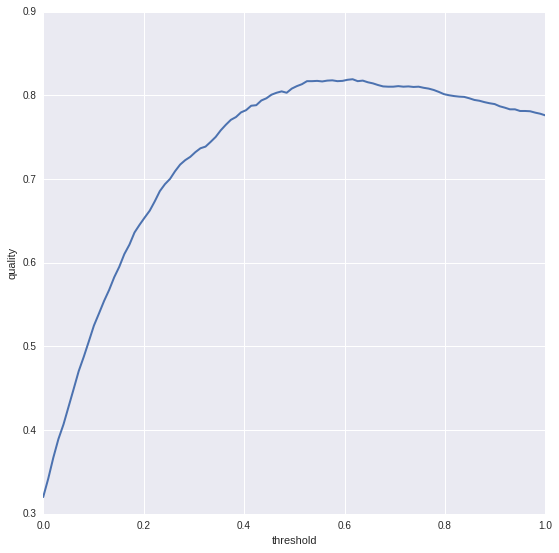

In [78]:
lsp = np.linspace(0, 1, 100)
fig = plt.figure(num=None, figsize=(9, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(lsp, [np.mean(np.abs((a>l) == y)) for l in lsp], lw=2)
plt.xlabel('threshold')
plt.ylabel('quality')
plt.show()

In [88]:
tmp = pd.DataFrame({'label':patient_id, 'y':y, 'a':a, 'ans': 0+(a>0.6)})
tmp['q'] = tmp.y == tmp.ans
print ('качество по сигналам = ' + str(tmp.q.mean()))
print ('качество по людям = ' + str(tmp.groupby('label')['q'].mean().mean()))

качество по сигналам = 0.817881887166
качество по людям = 0.714818858004


А теперь посчитаем AUC и построим РОК кривую.

In [80]:
from sklearn.metrics import roc_auc_score
print (roc_auc_score(y, a))

0.800193167599


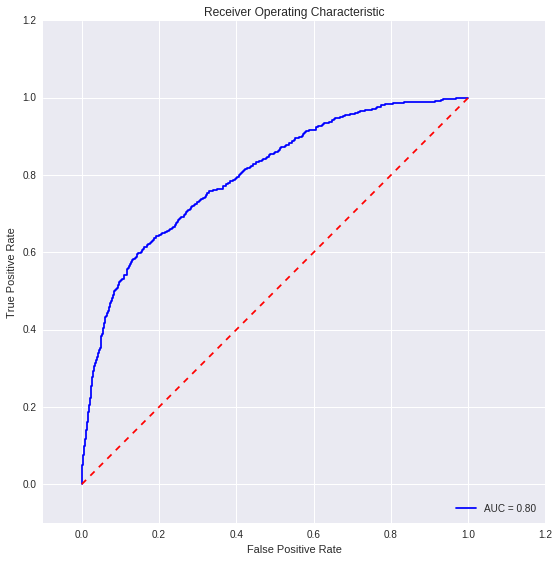

In [91]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
fig = plt.figure(num=None, figsize=(9, 9), dpi=80, facecolor='w', edgecolor='k')
false_positive_rate, true_positive_rate, thresholds = roc_curve(y, a)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Варьированием порога классификации можно добиваться улучшения-ухудшения в качестве по сигналам и по людям, например:

a = 0.6 => accuracy: human = 0.71, signal = 0.82

a = 0.5 => accuracy: human = 0.75, signal = 0.81

a = 0.45 => accuracy: human = 0.77, signal = 0.8

a = 0.4 => accuracy: human = 0.79, signal =  0.78

a = 0.3 => accuracy: human = 0.78, signal = 0.73

# Заключение

Что вошло в эту версию ноутбука:

1) Оригинальный метод Воронцова-Успенского (триграммы)

2) Добавление к нему слов, биграмм, тетраграмм

3) Добавление статических признаков (какие, смотреть в коде, но там средние, дисперсии, моменты, квантили от различных последовательностей, связанные с кардиаограммой).

Что было попробовано, но эффекта не дало:

1) PCA над признаками

2) Вместо частоности использовать TFIDF

3) Кодирование не троек, а просто изменений амплитуды, интервала, угла. Аналогично пары. (уделил этому мало времени, так что возомжно здесь есть некое рациональное зерно)

4) Стеккинг алгоритмов над различными паками фичей (например, только над триграммами, или только над стат фичами)

Что нужно было попробовать, но я не успел из-за своей лени:

1) Делать PCA не на всех фичах, а на раличных паках, при чем количество компонент варьировать в завимисости от размера пака (например, если всего при 5-грамме у нас 6^5 вариантов, то информативность кажлдой из них меньше, чем например у биграммы, где 6^2

2) Получше исселедовать ДРУГИЕ возможности кодирования кардиосигналов, а не только, как в оригинале Воронцова, то есть с помощью 6 букв. Никто не запрещает ввести новую величину или убрать одну их трех и получить алфавит другой мощности

3) Придумать алгоритм автоматического определения качества признака. Основная проблема, что со своим воображением я могу придумывать ничем неограниченное количество признаков, вся проверка работоспособности того или ного признака, сводилась к кросс-валидации с ним или без. Как простой вариант, можно считать АУК нового признака, и отбрасывать, если этот АУК принадлежит отрезку [0.5 - eps, 0.5 + eps]


С уважением, Викулин Всеволод